In [1]:
#Activation of the libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import openseespy.opensees as ops
import opsvis as opsv
import time

CTestEnergyIncr::test() - iteration: 1 current EnergyIncr: 0.0768026 (max: 1e-06)
	Norm deltaX: 0.0410734, Norm R: 3.73977
	deltaX: 0 -0.0410734 
	deltaR: 0 -3.73977 
CTestEnergyIncr::test() - iteration: 2 current EnergyIncr: 0.00718316 (max: 1e-06)
	Norm deltaX: 0.0120845, Norm R: 1.18882
	deltaX: 0 -0.0120845 
	deltaR: 0 -1.18882 
CTestEnergyIncr::test() - iteration: 3 current EnergyIncr: 0.000726958 (max: 1e-06)
	Norm deltaX: 0.0038029, Norm R: 0.382318
	deltaX: 0 -0.0038029 
	deltaR: 0 -0.382318 
CTestEnergyIncr::test() - iteration: 4 current EnergyIncr: 7.52003e-05 (max: 1e-06)
	Norm deltaX: 0.00121902, Norm R: 0.123379
	deltaX: 0 -0.00121902 
	deltaR: 0 -0.123379 
CTestEnergyIncr::test() - iteration: 5 current EnergyIncr: 7.83198e-06 (max: 1e-06)
	Norm deltaX: 0.000392979, Norm R: 0.0398595
	deltaX: 0 -0.000392979 
	deltaR: 0 -0.0398595 
CTestEnergyIncr::test() - iteration: 6 current EnergyIncr: 8.17449e-07 (max: 1e-06)
	Norm deltaX: 0.000126915, Norm R: 0.0128818
	deltaX: 0 -0.0

[[0.00000000e+00 0.00000000e+00]
 [3.42765608e-01 5.84850058e+01]
 [8.56795694e-01 9.20663135e+01]
 [1.41793529e+00 1.10404438e+02]
 [1.84345402e+00 1.59669951e+02]
 [2.13127298e+00 2.22613409e+02]
 [2.35574441e+00 2.89463588e+02]
 [2.54661208e+00 3.57925431e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.71654795e+00 4.27243741e+02]
 [2.716547

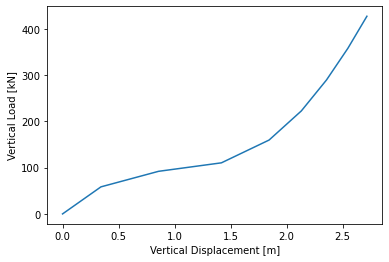

Running Time:  5.907206296920776  seconds


In [2]:
# Define the model
ops.wipe()
start = time.time()
### model('basic', '-ndm', ndm, '-ndf', ndf=ndm*(ndm+1)/2)
ops.model('basic', '-ndm', 2, '-ndf', 2)


ArcLengthAlpha = 0.58 #Initial value of alpha (arc length parameter)
ArcLengthLambda = 0.16  #Initial value of lambda (arc length parameter)
spring_stiffness = 95.364


#Geometric and material properties
E1 = 80000  # Modulus of elasticity in kN/m^2
A1 = 0.01  # Area of the section in m^2
E2 = 80000  # Modulus of elasticity in kN/m^2
A2 = 0.01 # Area of the section in m^2

# Load parameters
Px = 0
Py = 20 #kN

#Coordinates of the nodes
Lhalf = 2.1
L = 2*Lhalf
### node(nodeTag, *crds, '-ndf', ndf, '-mass', *mass, '-disp', *disp, '-vel', *vel, '-accel', *accel)
ops.node(1, 0.0, 0.0)
ops.node(2, Lhalf, 1.0) 
ops.node(3, Lhalf, 1.0)
ops.node(4, L, 0.0)


# Define boundary conditions (first and third nodes are free restrained)
### fix(nodeTag, *constrValues)
ops.fix(1, 1, 1)
ops.fix(3, 1, 1)
ops.fix(4, 1, 1)

# Define material
### uniaxialMaterial(matType, matTag, *matArgs)
ops.uniaxialMaterial('Elastic', 1, E1)
ops.uniaxialMaterial('Elastic', 2, E2)

# Spring stiffness in kN/m
 
ops.uniaxialMaterial('Elastic', 3, spring_stiffness)

# Define elements using corotTruss element (accounts for geometric nonlinearity)
### element(eleType, eleTag, *eleNodes, *eleArgs)
ops.element('corotTruss', 1, 1, 2, A1, 1)
ops.element('corotTruss', 2, 2, 4, A2, 2)
ops.element('zeroLength', 3, 3, 2, '-mat', 3, '-dir', 2)

# Define load at the middle node
### timeSeries(tsType, tsTag, *tsArgs)
ops.timeSeries('Linear', 1)
### pattern(patternType, patternTag, *patternArgs)
ops.pattern('Plain', 1, 1)

#Load
###load(nodeTag, *loadValues)
ops.load(2, 0, -Py)

# create SOE - System Of Equation
### system(systemType, *systemArgs)
ops.system('ProfileSPD')

# create DOF number
### numberer(numbererType, *numbererArgs)
ops.numberer('RCM')

# create constraint handler
### constraints(constraintType, *constraintArgs)
ops.constraints('Plain')

# create integrator
Nsteps=100 #Number of increments

ops.integrator('ArcLength', ArcLengthAlpha, ArcLengthLambda) 

# create algorithm
### algorithm(algoType, *algoArgs)
ops.algorithm('ModifiedNewton', '-initial') #MODIFIED NEWTON-RAPHSON!

# create test
### test(testType, *testArgs)
ops.test('EnergyIncr', 1.0e-6, 50, 4)

# create analysis object
### analysis(analysisType)
ops.analysis("Static")

#PERFORM ANALYSIS
data = np.zeros((Nsteps+1,2)) 
for j in range(Nsteps):
    ### analyze(numIncr=1, dt=0.0, dtMin=0.0, dtMax=0.0, Jd=0)
    ops.analyze(1) 
    data[j+1,0] = abs(ops.nodeDisp(2,2)) 
    data[j+1,1] = ops.getLoadFactor(1)*Py 
print(data)
results = pd.DataFrame(data, columns=['Displacement','Force'])
results.to_excel('Results - Arclength Method - RIKS AND WAMPNER.xlsx')

plt.plot(data[:,0], data[:,1])
plt.xlabel('Vertical Displacement [m]')
#plt.ylim(-30, 100)
plt.ylabel('Vertical Load [kN]')
plt.show()

end = time.time()
running_time = (end - start)
print('Running Time: ', running_time, ' seconds')